In [1]:
import os, sys
print("CWD:", os.getcwd())
print("sys.path[0]:", sys.path[0])

CWD: /workspaces/COMP560FinalProject/notebooks
sys.path[0]: /workspaces/COMP560FinalProject/notebooks


In [2]:
import os, sys

# Go up one directory from notebooks/ to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)

Added to sys.path: /workspaces/COMP560FinalProject


In [3]:
from src.model import load_raw_data, add_targets, run_classification_models

df = load_raw_data("../data/merged.csv")
df = add_targets(df)

df[["Country", "Year", "GDP_per_capita", "high_gdp"]].head()

,Country,Year,GDP_per_capita,high_gdp
0,Algeria,1990,2445.182658,1
1,Algeria,1991,1759.111407,1
2,Algeria,1992,1802.693008,1
3,Algeria,1993,1831.048573,1
4,Algeria,1994,1525.540789,1


In [4]:
results = run_classification_models(df, models=["logreg_gd", "logreg_liblinear"])

for name, res in results.items():
    print(f"{name}: accuracy={res.accuracy:.3f}, f1={res.f1:.3f}")

logreg_gd: accuracy=0.851, f1=0.864
logreg_liblinear: accuracy=0.848, f1=0.859


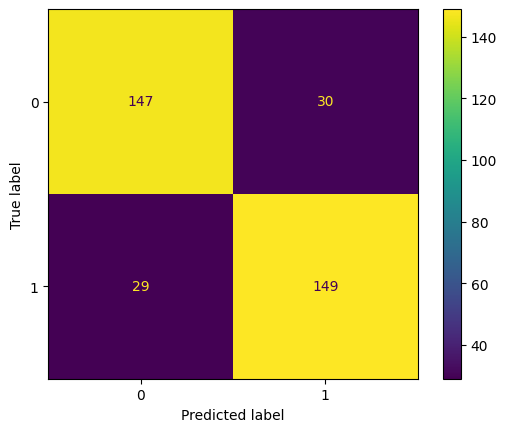

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.model import train_test_split_all, make_classification_pipeline

X_train, X_test, _, _, y_train, y_test = train_test_split_all(df)
pipe = make_classification_pipeline("logreg_gd")
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
